In [ ]:
import json

import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import shapely
import structlog
from shapely import Point, Polygon


def compute_ellipticity(points: np.array) -> float:
    """
    Compute ellipticity of a set of points.

    Parameters:
    - points (numpy array): Array of shape (n, 2) representing (x, y) coordinates of points.

    Returns:
    - ellipticity (float): Ellipticity value.
    """

    # Calculate the covariance matrix of the points
    cov_matrix = np.cov(points, rowvar=False)

    # Calculate eigenvalues and eigenvectors of the covariance matrix
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)

    # Sort eigenvalues in descending order
    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sorted_indices]
    eigenvectors = eigenvectors[:, sorted_indices]

    # Major and minor axis lengths are square roots of eigenvalues
    major_axis_length = np.sqrt(eigenvalues[0])
    minor_axis_length = np.sqrt(eigenvalues[1])

    # Compute ellipticity
    ellipticity = 1.0 - (minor_axis_length / major_axis_length)

    return ellipticity


def ellipticity(points: list[Point], threshold: int = 10, decimals: int = 4) -> float:
    points = [(i.x, i.y) for i in points]
    if len(points) < threshold:
        return None

    return np.round(compute_ellipticity(points), decimals)


def determine_stop_geometries(
    stops: gpd.GeoDataFrame,
    subgraphs: dict,
    time_marker: int = 39,
    suffix: str = "",
    concaveness_ratio: float = 0.2,
    # include_key: bool = True,
    include_empty: bool = False,
) -> pd.DataFrame:
    """
    Calculates convex and concave hulls of the accessible network, and also the ellipticity of the stops.

    While the convex hull is unambiguous, multiple concave hulls can be constructed.
    """
    records = []
    for row in stops.itertuples():
        accessible_stops = list(
            subgraphs.get(f"{row.stop_id}_network_{time_marker}", nx.Graph())
        )
        accessible_stops = stops[stops["stop_id"].isin(accessible_stops)].copy()
        if len(accessible_stops) == 0:
            if include_empty:
                records.append([row.stop_id, Polygon(), 0, Polygon(), 0, 0])
            continue
        points = accessible_stops.union_all()
        cv = shapely.convex_hull(points)
        cc = shapely.concave_hull(points, ratio=concaveness_ratio)
        el = ellipticity(accessible_stops.geometry.tolist())

        records.append(
            [
                row.stop_id,
                cv,
                round(cv.area / 1e6, 3),
                cc,
                round(cc.area / 1e6, 3),
                el,
            ]
        )
    columns = ["stop_id"] + [
        i + suffix
        for i in [
            "convex",
            "convex_area",
            "concave",
            "concave_area",
            "ellipticity",
        ]
    ]

    return pd.DataFrame.from_records(records, columns=columns)
    # if include_key:
    #     result["time"] = time_marker
    # return result

In [26]:
def determine_stop_geometries_from_walk(
    stops: gpd.GeoDataFrame,
    isochrones: gpd.GeoDataFrame,
    accessible_stops,
    crs: int = 23700,
) -> gpd.GeoDataFrame:
    records = []
    for row in stops.itertuples():
        if row.stop_id not in accessible_stops:
            logger.info(row.stop_id)
            continue
        accessible = stops[stops["stop_id"].isin(accessible_stops[row.stop_id])].copy()

        el = ellipticity(accessible.geometry.tolist())
        accessible_area = isochrones[
            (isochrones["stop_id"].isin(accessible_stops[row.stop_id]))
            & (isochrones["costing"] == "walk")
            & (isochrones["range"] == 5)
        ].copy()
        accessible_area_crs = accessible_area.to_crs(crs).union_all()
        records.append(
            [
                row.stop_id,
                accessible_area.union_all(),
                round(accessible_area_crs.area / 1e6, 3),
                el,
            ]
        )
    df = pd.DataFrame.from_records(
        records,
        columns=["stop_id", "geometry", "area", "ellipticity"],
    )
    return gpd.GeoDataFrame(df, crs=4326)

In [17]:
logger = structlog.get_logger()

In [4]:
CITY = "budapest"
# STOPS_FILENAME = "stops_gtfs_15min.csv"
# DICT_FILENAME = "subgraph_dict_10minute.pkl"
CRS = 23700
SUFFIX = ""
CITY = "budapest"
STOPS_FILENAME = "Budapest_stops_with_centrality.csv"
# DICT_FILENAME = "Budapest_10min_walbetclus.pkl"

In [20]:
CITY = "madrid"
CRS = 2062
STOPS_FILENAME = "Madrid_stops_with_centrality.csv"

In [29]:
CITY = "rotterdam"
CRS = 2193
STOPS_FILENAME = "Rotterdam_stops_with_centrality.csv"

In [36]:
CITY = "paris"
CRS = 2154
STOPS_FILENAME = "Paris_stops_with_centrality.csv"

In [37]:
with open(f"../data/stops/{CITY}/accessible_stops.json", "r") as fp:
    accessible_stops = json.load(fp)

In [38]:
all_stops = set([i for k, v in accessible_stops.items() for i in v])
len(all_stops)

24143

In [39]:
isochrones = pd.read_csv(f"../output/{CITY}/isochrones.csv")
isochrones["geometry"] = isochrones["geometry"].apply(shapely.from_wkt)
isochrones = gpd.GeoDataFrame(isochrones, geometry="geometry", crs=4326)

In [40]:
stops = pd.read_csv(f"../data/stops/{CITY}/{STOPS_FILENAME}", engine="pyarrow")
stops["geometry"] = stops.apply(lambda x: Point(x["stop_lon"], x["stop_lat"]), axis=1)
stops = gpd.GeoDataFrame(stops, geometry="geometry", crs=4326)
# stops.to_crs(CRS, inplace=True)
stops.head(3)

,Node,Eigenvector Centrality,Degree Centrality,Closeness Centrality,Betweenness Centrality,stop_id,clust,stop_lat,stop_lon,geometry
0,1.0,0.000139,0.000171,0.036953,0.000000,9375373,1,49.010502,2.559527,POINT (2.55953 49.0105)
1,1.0,0.000139,0.000171,0.036953,0.000000,9375374,1,49.010502,2.559527,POINT (2.55953 49.0105)
2,86.0,0.000725,0.000856,0.038477,0.000865,3672258,86,49.003367,2.564359,POINT (2.56436 49.00337)


In [ ]:
# stops[stops["stop_id"].isin(all_stops)]
# stops[stops["stop_id"].isin(accessible_stops.keys())]

In [41]:
sgfw = determine_stop_geometries_from_walk(stops, isochrones, accessible_stops, crs=CRS)
sgfw.to_csv(f"../output/{CITY}/stop_geometries_from_walk.csv", index=False)
sgfw.to_file(f"../output/{CITY}/stop_geometries_from_walk.geojson")

2025-03-06 16:04:48 [info     ] 9375373                       
2025-03-06 16:04:48 [info     ] 9375374                       
2025-03-06 16:04:48 [info     ] 3672258                       
2025-03-06 16:04:48 [info     ] 3672283                       
2025-03-06 16:04:48 [info     ] 7899212                       
2025-03-06 16:04:48 [info     ] 7899261                       
2025-03-06 16:04:48 [info     ] 7899355                       
2025-03-06 16:04:48 [info     ] 9217841                       
2025-03-06 16:04:48 [info     ] 9218043                       
2025-03-06 16:04:48 [info     ] 9218113                       
2025-03-06 16:04:48 [info     ] 9218149                       
2025-03-06 16:04:48 [info     ] 9375370                       
2025-03-06 16:04:48 [info     ] 9375375                       
2025-03-06 16:04:48 [info     ] 1696                          
2025-03-06 16:04:48 [info     ] 2506                          
2025-03-06 16:04:48 [info     ] 1639                   

<Axes: >

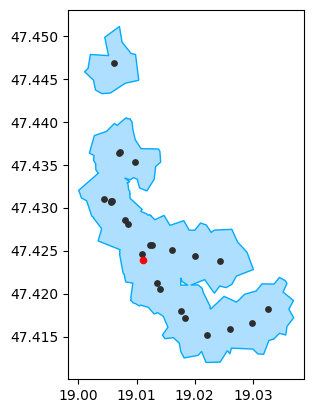

In [ ]:
stop = "009461"
# stop = "009749"
fig, ax = plt.subplots()
sgfw[sgfw["stop_id"] == stop].plot(ax=ax, fc="#afdfff", ec="#00aaff")
stops[
    (stops["stop_id"].isin(accessible_stops[stop])) & (stops["stop_id"] != stop)
].plot(ax=ax, color="#2d2d2d", markersize=15, zorder=5)
stops[stops["stop_id"] == stop].plot(ax=ax, color="red", markersize=20, zorder=10)

In [ ]:
# stops_accessibility = determine_stop_geometries(stops, subgraphs, suffix=SUFFIX)
# stops_accessibility.head(3)
# stops_accessibility.to_csv(f"../output/{CITY}/stop_geometries.csv", index=False)

In [ ]:
# try:
#     full = pd.read_csv(f"../output/{CITY}/stop_geometries.csv", engine="pyarrow")
# except FileNotFoundError:
#     # runs 12m for 10-minute only
#     full = pd.DataFrame()
#     for i in range(72):
#         sa = determine_stop_geometries(stops, subgraphs, time_marker=i)
#         sa["time"] = i
#         full = pd.concat([full, sa])
#     full.to_csv(f"../output/{CITY}/stop_geometries.csv", index=False)
#     full.drop(["convex", "concave"], axis=1).to_csv(
#         f"../output/{CITY}/stop_metrics.csv", index=False
#     )

In [ ]:
# def kernel(i: int) -> pd.DataFrame:
#     sa = determine_stop_geometries(stops, subgraphs, time_marker=i, include_empty=True)
#     sa["time"] = i
#     return sa


# with Pool(4) as p:
#     partials = p.map(kernel, range(72))

# full = pd.DataFrame()
# for i in partials:
#     full = pd.concat([full, i])

# full.to_csv(f"../output/{CITY}/stop_geometries.csv", index=False)
# full.drop(["convex", "concave"], axis=1).to_csv(
#     f"../output/{CITY}/stop_metrics.csv", index=False
# )